YF.download() has changed argument auto_adjust default to True


Failed to get ticker 'QQQ' reason: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Failed to get ticker 'SPY' reason: HTTPSConnectionPool(host='query1.finance.yahoo.com', port=443): Max retries exceeded with url: /v1/test/getcrumb (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1147)')))
[*********************100%***********************]  2 of 2 completed
/var/folders/dv/8w3yd93n07bbcdy1hqv1596w0000gn/T/ipykernel_7085/856861684.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace o


正在处理股票: QQQ


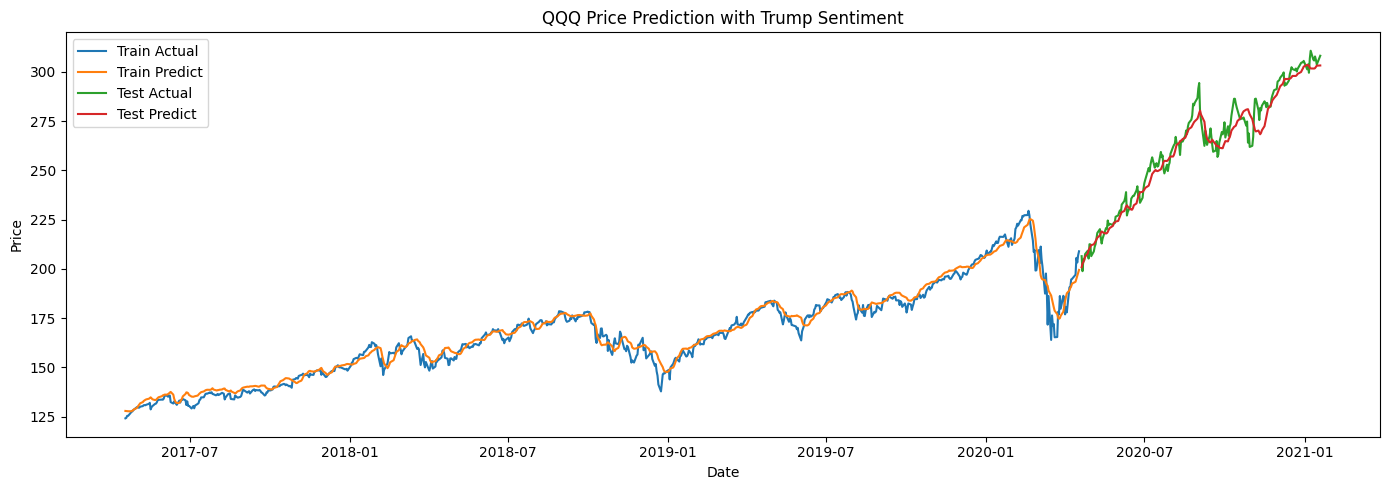

QQQ 训练集 MSE: 14.6667
QQQ 训练集 R²: 0.9708
QQQ 测试集 MSE: 36.2802
QQQ 测试集 R²: 0.9562

正在处理股票: SPY


/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


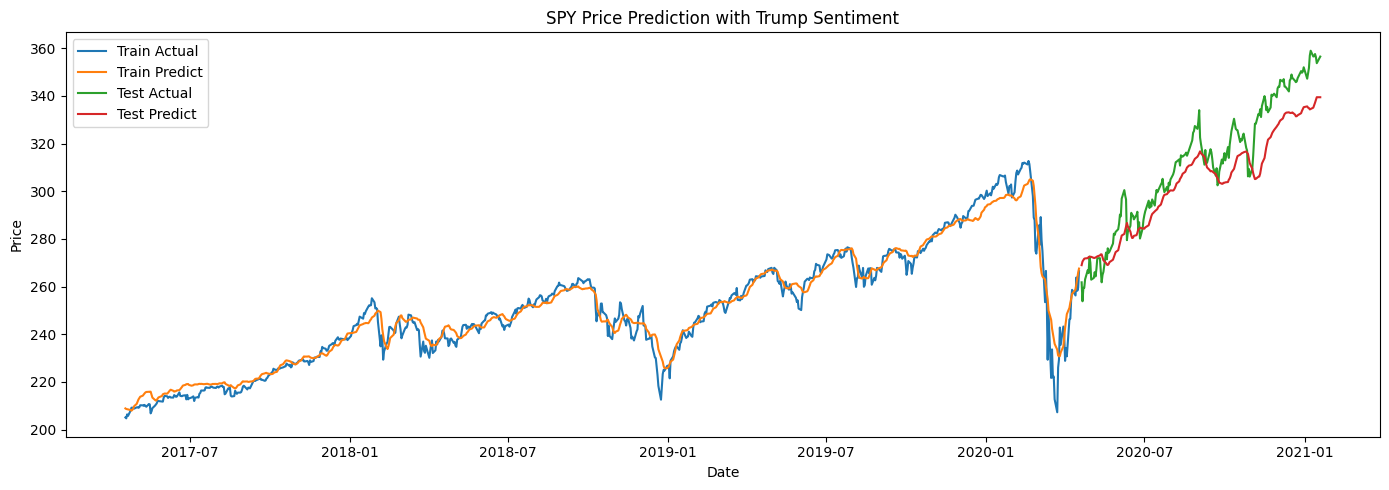

SPY 训练集 MSE: 22.4091
SPY 训练集 R²: 0.9621
SPY 测试集 MSE: 137.2201
SPY 测试集 R²: 0.8038


In [1]:
# 📦 安装依赖（如未安装）
# pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow transformers

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import re

# Step 1: 设置时间范围和股票代码
start_date = '2017-01-20'
end_date = '2021-01-20'
tickers = ['QQQ', 'SPY']

# Step 2: 读取美债收益率数据（假设已有本地 CSV）
treasury_data = pd.read_csv("./us_treasury_yields_daily.csv")
treasury_data['date'] = pd.to_datetime(treasury_data['date'])
treasury_data.set_index('date', inplace=True)
treasury_data = treasury_data[start_date:end_date]

# Step 3: 获取股票数据
stock_data = yf.download(tickers, start=start_date, end=end_date)[['Close', 'Volume']]
close_columns = [f"{ticker}_Close" for ticker in tickers]
volume_columns = [f"{ticker}_Volume" for ticker in tickers]
stock_data.columns = close_columns + volume_columns

# Step 4: 合并国债收益率和股票数据
data = stock_data.join(treasury_data[['US10Y']], how='inner')

# Step 5: 加载 Trump 推文并计算情绪得分
trump_df = pd.read_csv("./data/trump_sentiment_labeled_no_classification.csv")
trump_df['date'] = pd.to_datetime(trump_df['date'])
trump_df['day'] = trump_df['date'].dt.date

sentiment_daily = trump_df.groupby(['day', 'sentiment']).size().unstack(fill_value=0)
sentiment_daily['sentiment_score'] = sentiment_daily.get('positive', 0) - sentiment_daily.get('negative', 0)
sentiment_daily = sentiment_daily[['sentiment_score']]
sentiment_daily.index = pd.to_datetime(sentiment_daily.index)

# Step 6: 合并情绪得分到股市数据中
data = data.join(sentiment_daily, how='left')
data['sentiment_score'].fillna(0, inplace=True)
data.fillna(method='ffill', inplace=True)

# Step 7: 定义模型训练与预测函数
def train_and_predict_for_ticker(ticker, data, time_step=60):
    close_col = f"{ticker}_Close"
    volume_col = f"{ticker}_Volume"
    features = [close_col, volume_col, 'US10Y', 'sentiment_score']
    target = close_col

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[features])

    def create_dataset(data, time_step):
        X, y = [], []
        for i in range(len(data) - time_step):
            X.append(data[i:(i + time_step), :])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)

    X, y = create_dataset(scaled_data, time_step)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, len(features))))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), verbose=0)

    train_predict = model.predict(X_train, verbose=0)
    test_predict = model.predict(X_test, verbose=0)

    train_predict_full = np.zeros((train_predict.shape[0], len(features)))
    test_predict_full = np.zeros((test_predict.shape[0], len(features)))
    train_predict_full[:, 0] = train_predict[:, 0]
    test_predict_full[:, 0] = test_predict[:, 0]

    train_predict = scaler.inverse_transform(train_predict_full)[:, 0]
    test_predict = scaler.inverse_transform(test_predict_full)[:, 0]

    y_train_full = np.zeros((y_train.shape[0], len(features)))
    y_test_full = np.zeros((y_test.shape[0], len(features)))
    y_train_full[:, 0] = y_train
    y_test_full[:, 0] = y_test
    y_train_inv = scaler.inverse_transform(y_train_full)[:, 0]
    y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]

    train_mse = mean_squared_error(y_train_inv, train_predict)
    train_r2 = r2_score(y_train_inv, train_predict)
    test_mse = mean_squared_error(y_test_inv, test_predict)
    test_r2 = r2_score(y_test_inv, test_predict)

    plt.figure(figsize=(14, 5))
    plt.plot(data.index[time_step:train_size + time_step], y_train_inv, label='Train Actual')
    plt.plot(data.index[time_step:train_size + time_step], train_predict, label='Train Predict')
    plt.plot(data.index[train_size + time_step:], y_test_inv, label='Test Actual')
    plt.plot(data.index[train_size + time_step:], test_predict, label='Test Predict')
    plt.title(f'{ticker} Price Prediction with Trump Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_mse, train_r2, test_mse, test_r2

# Step 8: 运行所有股票预测
for ticker in tickers:
    print(f"\n正在处理股票: {ticker}")
    train_mse, train_r2, test_mse, test_r2 = train_and_predict_for_ticker(ticker, data)
    print(f"{ticker} 训练集 MSE: {train_mse:.4f}")
    print(f"{ticker} 训练集 R²: {train_r2:.4f}")
    print(f"{ticker} 测试集 MSE: {test_mse:.4f}")
    print(f"{ticker} 测试集 R²: {test_r2:.4f}")
